__собираем статистики по объявлениям о продаже квартир__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
# !pip install plotly ipywidgets plotly-geo

In [2]:
# import re
# import numpy as np
# from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
# import plotly
# import contextily as ctx
# from shapely.geometry import Polygon

/opt/venv/jupyter_0/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.0-CAPI-1.17.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
# tqdm.pandas()
# pd.options.plotting.backend = 'plotly'

In [4]:
# !ls -1 data

In [5]:
# import shapely
# shapely.__version__
# '1.8.4'

In [6]:
# !pip install greppo==0.0.32
# !pip install shapely==1.8.2

In [7]:
# !pip install --upgrade pip

In [8]:
# !pip install --upgrade pygeos==0.10.2

In [9]:
# !pip freeze > requirements.txt
# !pip install -r requirements.txt

## считываем данные

In [10]:
data_file = 'data/data_flat.pkl'

In [11]:
cols = ['title','adr','latitude','longitude','priceM','dt']
df = pd.read_pickle(data_file)
# df['dt'] = pd.to_datetime( df['ts'].dt.date )
df['dt'] = df['ts'].dt.date
print(len(df))
df.sample(3)[cols]

45450


,title,adr,latitude,longitude,priceM,dt
19953,"1-к. квартира, 38 м², 9/9 эт.","Севастополь, улица Горпищенко, д. 139",44.582459,33.576824,5.30,2022-09-26
728,"2-к. квартира, 49,7 м², 9/16 эт.","Севастополь, улица Степаняна, 2Ак2",44.59,33.47,12.00,2022-08-26
24545,"1-комн. апарт., 28 м², 4/5 этаж","Севастополь, район Балаклавский, шоссе Фиолентовское, 134 к5",44.50,33.49,3.90,2022-09-08


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45450 entries, 0 to 45449
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   title          45450 non-null  object        
 1   price          45450 non-null  int64         
 2   adr_orig       45450 non-null  object        
 3   description    45450 non-null  object        
 4   obj_name       45450 non-null  object        
 5   ts             45450 non-null  datetime64[ns]
 6   avito_page     23271 non-null  float64       
 7   place          45450 non-null  object        
 8   nrooms         45450 non-null  int64         
 9   floor          45450 non-null  int64         
 10  nfloors        45450 non-null  int64         
 11  area           45450 non-null  float64       
 12  is_studio      45450 non-null  bool          
 13  is_apartment   45450 non-null  bool          
 14  is_part        45450 non-null  bool          
 15  is_auction     4545

In [13]:
# берём объявления с геометкой
print(len(df))
df = df[ (~df['latitude'].isnull()) ].reset_index(drop=True)
print(len(df))

45450
45450


### ограничиваем тип объекта 

In [14]:
print(len(df))
# выкидываем "ущербные" варианты 
df = df.query('~(is_studio|is_apartment|is_part|is_auction|is_openspace|is_SNT|is_roof)&(nrooms>0)&(nrooms<4)')
print(len(df))
df = df.query('priceM>1.') # выкидываем предожения с аномально низкой ценой
print(len(df))

45450
39379
39378


In [15]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
gdf.sample(3)[['title','adr','latitude','longitude','priceM']]

,title,adr,latitude,longitude,priceM
5275,"1-к. квартира, 30 м², 4/5 эт.","Севастополь, улица Меньшикова, 25",44.59,33.49,5.25
45179,"3-комн. кв., 67,7 м², 6/10 этаж","Севастополь, район Гагаринский, 5-й, улица Александра Маринеско, 4А",44.575692,33.466161,8.60
7951,"3-к. квартира, 75 м², 4/5 эт.","Севастополь, проспект Победы, 33",44.59,33.57,7.40


In [16]:
df.sample(10)[['title','adr','url']].to_dict('records') 

[{'title': '1-комн. кв., 39,7 м², 4/10 этаж',
  'adr': 'Севастополь, район Гагаринский, Летчики, улица Колобова, 18/1',
  'url': 'https://sevastopol.cian.ru/sale/flat/279658623/'},
 {'title': '1-к. квартира, 41,7\xa0м², 12/12\xa0эт.',
  'adr': 'Севастополь, шоссе Лабораторное, д. 33, секц. 4',
  'url': 'https://avito.ru/2333681557'},
 {'title': '1-к. квартира, 48\xa0м², 5/10\xa0эт.',
  'adr': 'Севастополь, улица Военных Строителей, д. 10/3А',
  'url': 'https://avito.ru/2244649852'},
 {'title': '3-к. квартира, 89,4\xa0м², 5/9\xa0эт.',
  'adr': 'Севастополь, улица Генерала Крейзера, д. 8, корп. 7',
  'url': 'https://avito.ru/2050496689'},
 {'title': '1-комн. кв., 29,8 м², 5/9 этаж',
  'adr': 'Севастополь, район Нахимовский, Северная сторона, улица Буряка, 9',
  'url': 'https://sevastopol.cian.ru/sale/flat/279012145/'},
 {'title': '1-к. квартира, 33\xa0м², 1/3\xa0эт.',
  'adr': 'Севастополь,аллея Защитников 35-й Батареи, д. 11а',
  'url': 'https://avito.ru/2372800340'},
 {'title': '1-комн

In [17]:
del df

In [18]:
gdf[['title','adr','priceM','geometry']].sample(100).explore()

## общая статистика

### количество предложений

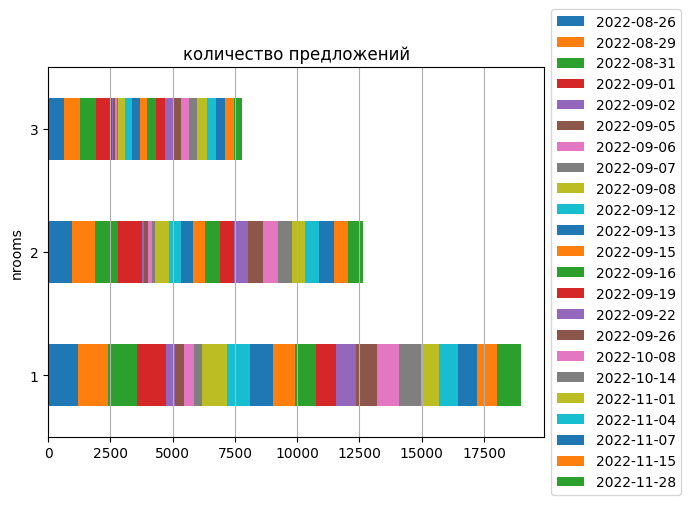

In [19]:
fig = ( # количество предложений
    gdf
    .groupby(['dt','nrooms'])
    .size().reset_index()
    .pivot(index='nrooms', columns='dt', values=0)
    .plot
    .barh(legend=False,title='количество предложений',stacked=True)
)
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

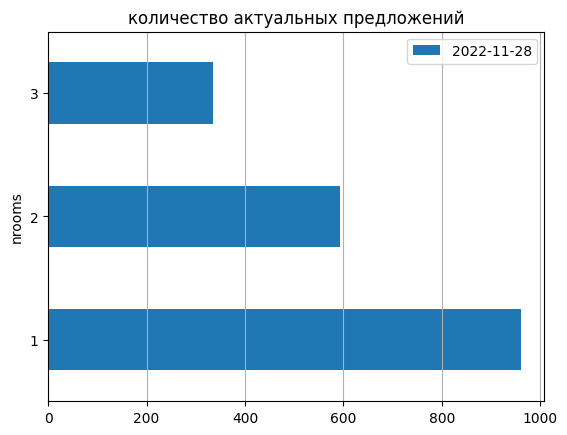

In [20]:
fig = ( # количество актуальных предложений
    gdf[ gdf['dt'] == gdf['dt'].max() ]
    .groupby(['dt','nrooms'])
    .size().reset_index()
    .pivot(index='nrooms', columns='dt', values=0)
    .plot
    .barh( legend=False,title='количество актуальных предложений') #, stacked=True )
)
fig.legend() # loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

### изменение цены

In [21]:
stat = gdf.groupby(['nrooms','dt'])['priceM'].describe(percentiles=[.01,.1,.25,.5,.75,.9])
# stat

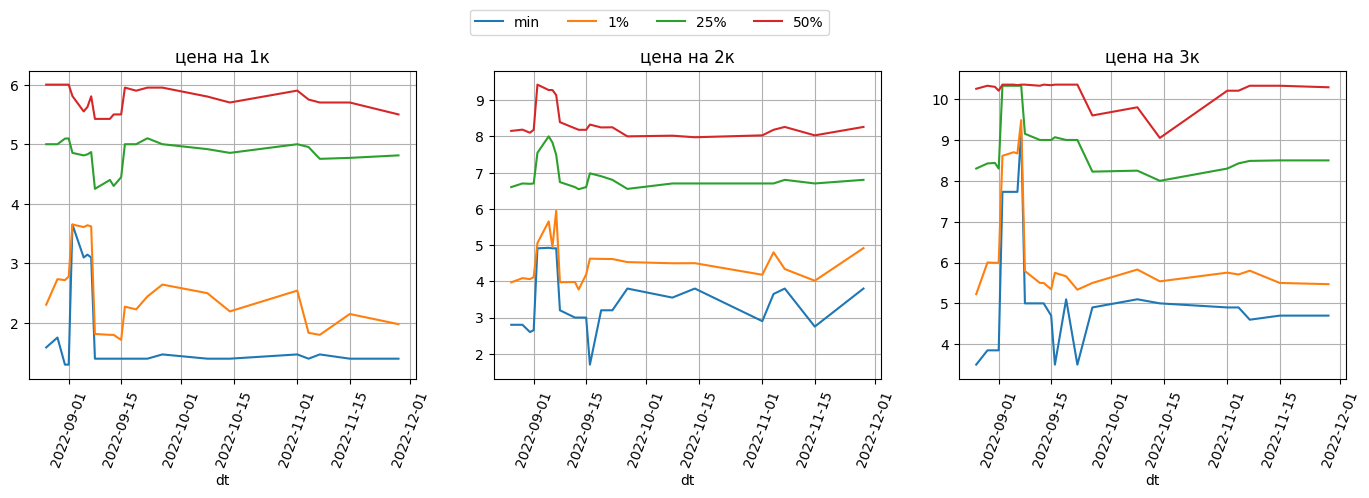

In [22]:
import matplotlib.pyplot as plt

sizes = [1,2,3,]
cols = ['min','1%','25%','50%']
fig, ax = plt.subplots(1,len(sizes),figsize=(17,4), sharey=False )
for i,k in enumerate(sizes): 
    stat.loc[k,cols].plot(title=f'цена на {k}к', grid=True,ax=ax[i],legend=False, rot=70 )   
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 1.05))    

### гексагональная сетка и медиана актуальной цены

In [23]:
from shapely.geometry import MultiPoint

frame_all = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

frame_all.explore()


In [24]:
# frame_all.to_file('data/frame_all.geojson', driver='GeoJSON')

In [25]:
import h3
from shapely.geometry import Polygon

def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [26]:
grid = cover_grid_hexagonal( frame_all.geometry.values[0],cell_size=6 )
print(len(grid))
grid.sample(2)

24


,hex_id,geometry
15,862d2d4b7ffffff,"POLYGON ((33.55659 44.71016, 33.53515 44.68076, 33.56208 44.65198, 33.61044 44.65261, 33.63190 44.68201, 33.60499 44.71079, 33.55659 44.71016))"
23,862d2d4a7ffffff,"POLYGON ((33.55110 44.76831, 33.52964 44.73892, 33.55659 44.71016, 33.60499 44.71079, 33.62646 44.74017, 33.59953 44.76893, 33.55110 44.76831))"


In [27]:
grid_values = ( 
    grid
    .sjoin( gdf[ gdf['dt']==gdf['dt'].max() ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## ограничиваем по район поиска

In [28]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
    { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
    for nm,f in frames_index.values
],crs='epsg:4326',)

frames

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"
1,"Севастополь, парк 60-летия СССР","POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))"
2,"Севастополь, Хрусталёва/Хрюкина","POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))"
3,"Севастополь, Геловани/Коломийца","POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))"
4,"Севастополь, Музыки/Бирюзова","POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))"
5,"Севастополь, кр.горка","POLYGON ((33.53426 44.59526, 33.54470 44.58945, 33.54804 44.58596, 33.55346 44.58519, 33.55707 44.57912, 33.56296 44.57711, 33.54048 44.56941, 33.53004 44.59308, 33.53426 44.59526))"
6,"Севастополь, Малахов курган","POLYGON ((33.54313 44.60612, 33.55331 44.61155, 33.55676 44.60803, 33.55772 44.60255, 33.55385 44.60019, 33.54414 44.60247, 33.54313 44.60612))"


In [29]:
frames.explore('area_name', legend=True)

In [30]:
# frames.to_file('data/frames.geojson', driver='GeoJSON')

In [31]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
'Севастополь, район Острякова',
# 'Севастополь, Малахов курган',
]

# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
print(len(gdf))
gdf_ = gdf.sjoin( frame_, how='inner', predicate='within') 
print(len(gdf_))

39378
3316


In [32]:
frames.iloc[[0]]

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"


In [33]:
# новые (актуальные) предложения
# gdf_[gdf_['ts']>ts][['title','priceM','adr','geometry']].explore( legend=False)
gdf_[['title','priceM','adr','geometry']].explore( legend=False)

In [34]:
locations = ' | '.join(area_name)
locations

'Севастополь, район Острякова'

### количество предложений

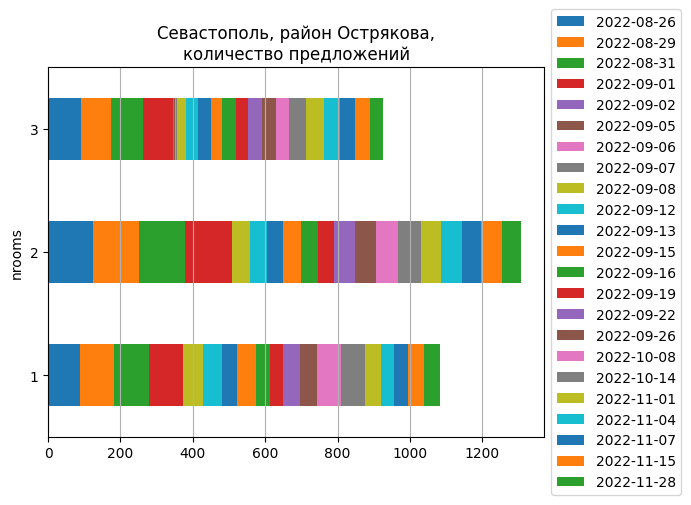

In [35]:
fig = ( # количество предложений
    gdf_.groupby(['dt','nrooms'])
    .size().reset_index()
    .pivot(index='nrooms', columns='dt', values=0)
    .plot.barh(legend=False,title=f'{locations},\nколичество предложений',stacked=True)
)
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

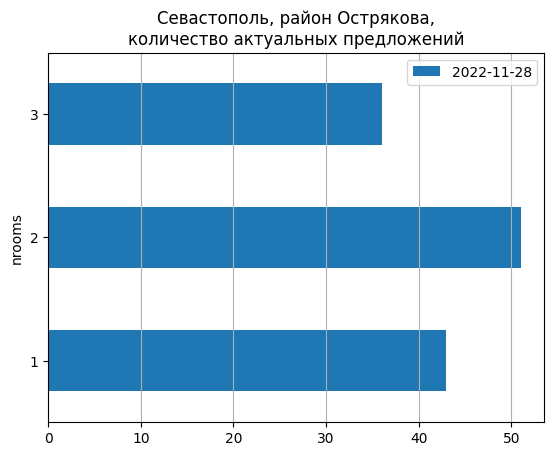

In [36]:
fig = ( # количество актуальных предложений
    gdf_[ gdf_['dt'] == gdf_['dt'].max() ]
    .groupby(['dt','nrooms'])
    .size().reset_index()
    .pivot(index='nrooms', columns='dt', values=0)
    .plot.barh(legend=False,title=f'{locations},\nколичество актуальных предложений',stacked=True)

)
fig.legend() #loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

### изменение цены

In [37]:
stat = gdf_.groupby(['nrooms','dt',])['priceM'].describe(percentiles=[.01,.1,.25,.5,.75,.9])
# stat

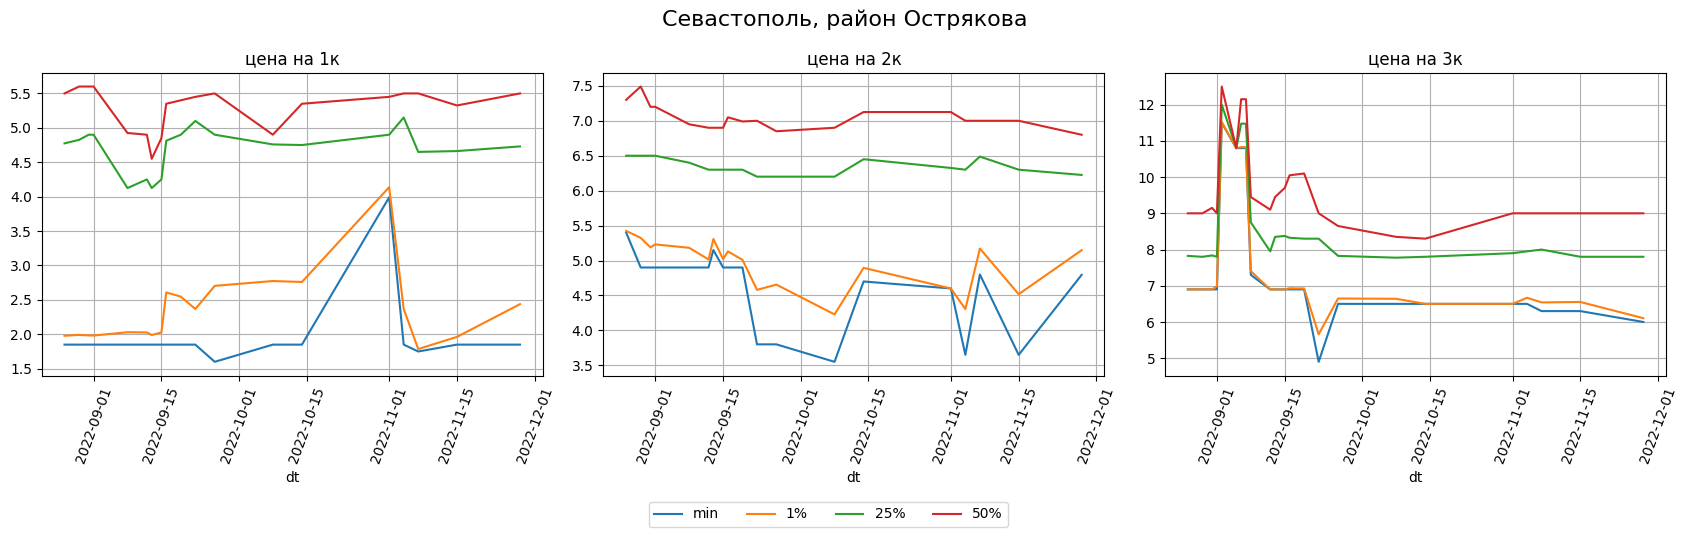

In [41]:
import matplotlib.pyplot as plt

sizes = [1,2,3,]
cols = ['min','1%','25%','50%']
fig, ax = plt.subplots(1,len(sizes),figsize=(17,5), sharey=False )
for i,k in enumerate(sizes): 
    stat.loc[k,cols].plot(title=f'цена на {k}к', grid=True,ax=ax[i],legend=False, rot=70 )   
    
fig.suptitle(locations, fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

### гексагональная сетка и  медиана актуальной цены

In [42]:
grid = cover_grid_hexagonal( frame_.geometry.values[0], cell_size=9 )
print(len(grid))
grid.sample(2)

54


,hex_id,geometry
27,892d2894213ffff,"POLYGON ((33.52497 44.57415, 33.52465 44.57236, 33.52673 44.57120, 33.52914 44.57183, 33.52947 44.57362, 33.52738 44.57478, 33.52497 44.57415))"
17,892d2894243ffff,"POLYGON ((33.53025 44.56530, 33.52993 44.56351, 33.53201 44.56235, 33.53442 44.56297, 33.53475 44.56476, 33.53266 44.56593, 33.53025 44.56530))"


In [43]:
grid_values = ( 
    grid
    .sjoin( gdf[ gdf['dt']==gdf['dt'].max() ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)